# PULSEE Quantum Computing Demo
### Lucas Brito 
This is a demo of the quantum computing module of PULSEE. If the `pulsee` 
package has been installed in this environment, we can import the quantum
computing module with 

In [1]:
from pulsee.quantum_computing import * 
from pulsee.plot import plot_real_part_density_matrix
import qutip as qt

We can create a `QubitSpace` object; this is an implementation of the 
two-dimensional Hilbert space which contains qubits. 

In [2]:
qs = QubitSpace()

From this `QubitSpace` we can generate a basis ket out of the bits which it 
represents. For example, if we want the ket $|0 \rangle$:

In [3]:
q = qs.basis_ket_from_indices([0])

This object is of the type `QubitState`:

In [4]:
type(q)

pulsee.quantum_computing.QubitState

The `QubitState` class implements a `density_matrix` property which can be 
used to study that state's density matrix. 

In [5]:
q.density_matrix
# or 	
q.get_density_matrix()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

Let us study the effect of applying particular gates to this qubit. As a sanity 
check, we can apply the Pauli-X gate (`Quantum_Computing.pauli_x`) to see that, 
in this simulation, it indeed functions as quantum analogue of the classical NOT
gate (i.e., it transforms $|0\rangle \doteq [1 \; 0 ]$ to $|1\rangle \doteq [ 0 \; 1]$): 

In [6]:
pauli_x(q).matrix

array([0.+0.j, 1.+0.j])

Let's study the effect that certain gates have on the density matrix of a state. 
The Hadamard gate creates a superposition out of a basis qubit; we thus expect 
the density matrix to have off-diagonal elements:

In [7]:
hadamard(q).density_matrix.full()


array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

Indeed we obtain the matrix 
$$
\begin{bmatrix}
1/2 & 1/2\\ 1/2 & 1/2
\end{bmatrix}
$$
as is to be expected from the ket $(1/\sqrt{2})(|0\rangle + |1 \rangle)$. We see 
that if our observable of choice is spin, the Hadamard gate has the effect of 
rotating the Bloch sphere vector by $\pi/2$ about the $y$-axis.

Now create a composite qubit space (the tensor product of two qubit spaces, used 
treat, for example, the total spin of two particles) in order to study some more
complicated gates. 

In [8]:
cqs = CompositeQubitSpace(2) # choose n = 2 for the composition of two spaces
							 # (i.e., two particles).

We can create the state ket $|10\rangle$: one spin-up particle and one spin-down 
particle. 

In [9]:
q = cqs.basis_ket_from_indices([1, 0])
q.matrix

array([0., 0., 1., 0.])

A commonly used binary gate is the controlled-NOT (CNOT) gate:
$$
\text{CNOT}
=
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$
which is known to entangle a "target" qubit and a "controller" qubit; see
Barnett (2009) pg. 247.  The action of the CNOT gate on the target qubit depends
on the state of the controller qubit: If the control is $|0\rangle$ the target
is unchanged; if the control is $|1\rangle$, the CNOT gate acts on the target as
if it is a NOT (Pauli-X) gate. Let us see this in action. Construct the states

In [10]:

control = qs.basis_ket_from_indices([0])
target = qs.basis_ket_from_indices([0])

and take the tensor product to create a composite state:

In [11]:
product_qubit = qt.tensor(control, target)
# or 
product_qubit = control * target # pulsee overrides multiplication operation for 
								 # QubitState objects.

product_qubit.matrix

array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

we see that applying the CNOT gate has no effect because the control is
$|0\rangle$: 

In [12]:
cnot(product_qubit).full()

array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

However, if we instead use the state $|10\rangle$, we expect to obtain
$|11\rangle$:

In [13]:
product_qubit = qs.basis_ket_from_indices([1]) * qs.basis_ket_from_indices([0])
cnot(product_qubit).matrix

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [1.+0.j]])

It is not difficult to see how the CNOT gate creates entangled states. Loosely 
speaking, whether the target qubit was "flipped" depends on the state of the 
controller qubit. Thus providing a superposed controller qubit and
subsequently collapsing said qubit leads to a collapse of the target 
qubit; the value of this collapsed target qubit depends on observed value of the 
controller qubit.

Then if we construct the states $(1/\sqrt{2})(|0\rangle + |0 \rangle)$ and 
$|0\rangle $ and take their product:

In [14]:
control = qs.make_state(coeffs=[1 / np.sqrt(2), 1 / np.sqrt(2)])
target = qs.basis_ket_from_indices([0])

product_qubit = control * target 

then apply the CNOT gate and inspect the resulting density matrix 

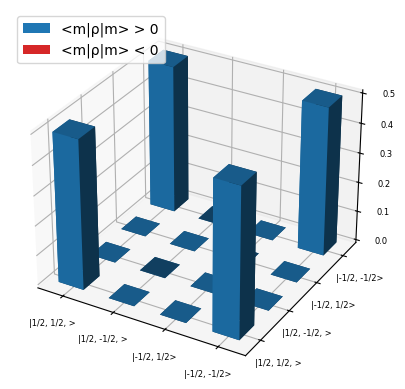

In [15]:
bell_state = cnot(product_qubit)
fig = plot_real_part_density_matrix(bell_state.density_matrix, many_spin_indexing=[2, 2])
#fig.savefig('/home/lzawbrito/PythonProjects/PULSEE/notes/pulsee-paper/ForReSubmissionIlija/Figures/CorrStateDensityMatrix', dpi=150)

as well as the reduced density matrix's trace:

In [16]:
reduced_density_matrix = bell_state.get_reduced_density_matrix(0)
# take real component to interpret more easily
import numpy as np 

np.trace(np.matmul(reduced_density_matrix.full(), reduced_density_matrix.full()))

(0.5000000000000002+0j)

The diagonal elements of this matrix are as expected—the trace of the reduced 
density matrix squared is less than one and this is not a pure density
matrix, indicating that this is an entangled state; see Baaquie (2013) pages
93-113.

As a final demonstration, we will verify that it is possible to obtain a so-called Bell state using a Hadamard gate and a CNOT gate. First construct two state vectors:

In [17]:
q1 = qs.basis_ket_from_indices([0])
q2 = qs.basis_ket_from_indices([0])

Now apply the Hadamard gate to `q1`, take the states' tensor product product, and run them through a CNOT gate:

In [18]:
q1 = hadamard(q1)

q1q2 = q1 * q2 
q1q2 = cnot(q1q2)

We expect this state to be a superposition $1/\sqrt{2}(|00\rangle + |11\rangle)$; as such we look for the coefficients of the projection onto the computational basis: 

In [19]:
[np.vdot(b, q1q2.matrix) for b in q1q2.qubit_space.onb_matrices()]

[(0.7071067811865475+0j), 0j, 0j, (0.7071067811865475+0j)]